<a href="https://colab.research.google.com/github/benihime91/retinanet_pet_detector/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Sat Sep 19 09:07:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

**Setup Google Collab**

In [3]:
# install dependencies
!pip install pytorch-lightning omegaconf --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet

     |████████████████████████████████| 409kB 3.0MB/s 
     |████████████████████████████████| 276kB 12.7MB/s 
     |████████████████████████████████| 2.8MB 13.4MB/s 
     |████████████████████████████████| 829kB 31.5MB/s 
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
     |████████████████████████████████| 952kB 2.9MB/s 


In [ ]:
# Run this cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

**Untar Data:**

In [4]:
# unzip the data assuming the `The Oxford-IIIT Pet Dataset` is present 
# as /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz
# to download the dataset go to this link:
# https://www.robots.ox.ac.uk/~vgg/data/pets/
!tar xf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/ 

**Clone the Repo:**

In [5]:
!git clone --recurse-submodules -j8 https://github.com/benihime91/retinanet_pet_detector.git

Cloning into 'retinanet_pet_detector'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 708 (delta 6), reused 13 (delta 5), pack-reused 693
Receiving objects: 100% (708/708), 37.90 MiB | 35.09 MiB/s, done.
Resolving deltas: 100% (408/408), done.
Submodule 'pytorch_retinanet' (https://github.com/benihime91/pytorch_retinanet.git) registered for path 'pytorch_retinanet'
Cloning into '/content/retinanet_pet_detector/pytorch_retinanet'...
remote: Enumerating objects: 12, done.        
remote: Counting objects: 100% (12/12), done.        
remote: Compressing objects: 100% (7/7), done.        
remote: Total 1742 (delta 5), reused 11 (delta 5), pack-reused 1730        
Receiving objects: 100% (1742/1742), 55.13 MiB | 28.40 MiB/s, done.
Resolving deltas: 100% (1169/1169), done.
Submodule path 'pytorch_retinanet': checked out '00b3f8e389ba1803c1fe4a37ecde50c02510317c'


**Imports:**

In [7]:
import sys
import os
import warnings

os.chdir("/content/retinanet_pet_detector")
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
from train import main
from references.data_utils import _get_logger
import argparse
from omegaconf import OmegaConf
import pandas as pd
from references import Visualizer
from references.utils import get_label_dict
import numpy as np

# Set up logging
logger = _get_logger()

**Preprare Data:**

In [9]:
# Convert xml files to a csv file
!python references/data_utils.py \
    --action create \
    --img_dir "/content/oxford-iiit-pet/images" \
    --annot_dir "/content/oxford-iiit-pet/annotations/xmls" \
    --labels "/content/retinanet_pet_detector/data/labels.names" \
    --output_dir "/content/retinanet_pet_detector/data/"

[09/19 09:08:35 data_utils]: Converting xml files to a csv file
[09/19 09:08:35 data_utils]: Image Directory: /content/oxford-iiit-pet/images
[09/19 09:08:35 data_utils]: Annotation Directory: /content/oxford-iiit-pet/annotations/xmls
[09/19 09:08:35 data_utils]: Path to labels: /content/retinanet_pet_detector/data/labels.names
[09/19 09:08:35 data_utils]: Number of unique classes found: 37
[09/19 09:08:35 data_utils]: csv file saved as /content/retinanet_pet_detector/data/data-full.csv


In [10]:
# Create train, validaiton and test splits in the data
!python references/data_utils.py \
    --action split \
    --csv "/content/retinanet_pet_detector/data/data-full.csv"\
    --valid_size 0.3 \
    --test_size 0.5 \
    --output_dir "/content/retinanet_pet_detector/data/"

[09/19 09:08:36 data_utils]: path to the given csv file : /content/retinanet_pet_detector/data/data-full.csv
[09/19 09:08:36 data_utils]: Creating train, validation and test splits
[09/19 09:08:37 data_utils]: Number of training examples=2580
[09/19 09:08:37 data_utils]: Number of validation examples=1843
[09/19 09:08:37 data_utils]: Number of test examples=1843
[09/19 09:08:37 data_utils]: Files saved to /content/retinanet_pet_detector/data/


In [11]:
df = pd.read_csv("/content/retinanet_pet_detector/data/train.csv")
df.head()

filename  ...  labels
0  /content/oxford-iiit-pet/images/german_shortha...  ...      14
1  /content/oxford-iiit-pet/images/english_setter...  ...      13
2  /content/oxford-iiit-pet/images/leonberger_107...  ...      19
3  /content/oxford-iiit-pet/images/saint_bernard_...  ...      28
4  /content/oxford-iiit-pet/images/shiba_inu_189.jpg  ...      31

[5 rows x 9 columns]

In [12]:
label_dict = get_label_dict("/content/retinanet_pet_detector/data/labels.names")
vis = Visualizer(label_dict)

[09/19 09:08:40 references.display_preds]: visualizer initialized


In [13]:
np.random.seed(123)

def display_random_image():
    idx = np.random.randint(0, len(df))
    image_id = df.filename[idx]
    locs = df.loc[df.filename == image_id]
    boxes = locs[['xmin','ymin','xmax','ymax']].values
    labels = locs['labels'].values
    vis.draw_bboxes(image_id, boxes, labels)

[09/19 09:08:44 references.display_preds]: Found 1 bounding box(s) on the given image


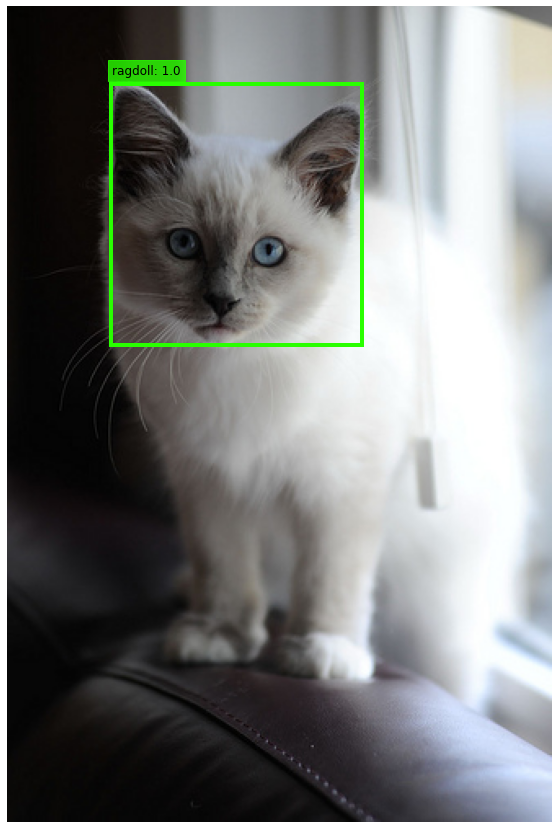

In [14]:
display_random_image()

[09/19 09:08:46 references.display_preds]: Found 1 bounding box(s) on the given image


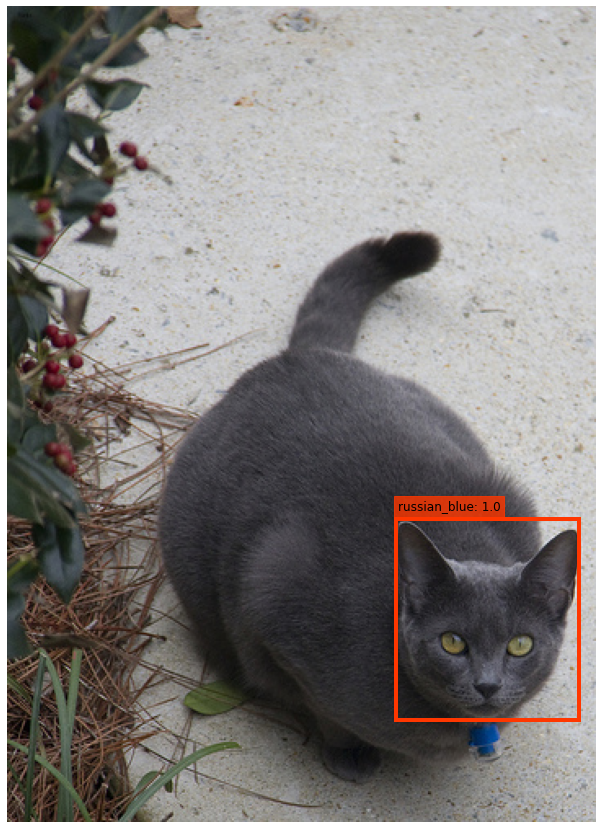

In [15]:
display_random_image()

In [16]:
# Remove previous logs if present
try:
    import shutil
    shutil.rmtree("/content/drive/My Drive/retianet-pets")
except:
    pass

try:
    import shutil
    shutil.rmtree("/content/logs")
except:
    pass

In [19]:
# load the config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")

# Modify some config parameters
config.hparams.train_csv = "/content/retinanet_pet_detector/data/train.csv"
config.hparams.valid_csv = "/content/retinanet_pet_detector/data/valid.csv"
config.hparams.test_csv  = "/content/retinanet_pet_detector/data/test.csv"
config.hparams.train_batch_size = 16
config.trainer.model_checkpoint.params.filepath = "/content/drive/My Drive/retianet-pets"
config.trainer.logger.params.save_dir = "/content/logs/"
config.trainer.flags.check_val_every_n_epoch = 10
config.trainer.flags.max_epochs = 80
# Save the modified config file
OmegaConf.save(config=config, f="/content/retinanet_pet_detector/main.yaml")

In [22]:
# view config 
logger.name = "/content/retinanet_pet_detector/main.yaml"
logger.info(msg=f"\nConfiguration File:  \n{OmegaConf.to_yaml(config)}")

[09/19 09:10:03 /content/retinanet_pet_detector/main.yaml]: 
Configuration File:  
model:
  backbone_kind: resnet34
  num_classes: 37
  freeze_bn: true
  min_size: 800
  max_size: 800
hparams:
  train_csv: /content/retinanet_pet_detector/data/train.csv
  train_batch_size: 16
  valid_csv: /content/retinanet_pet_detector/data/valid.csv
  valid_batch_size: 32
  test_csv: /content/retinanet_pet_detector/data/test.csv
  test_batch_size: 32
  iou_types: bbox
  optimizer:
    class_name: torch.optim.SGD
    params:
      lr: 0.002
      weight_decay: 0.01
      momentum: 0.9
  scheduler:
    class_name: torch.optim.lr_scheduler.MultiStepLR
    params:
      milestones:
      - 60
      - 75
      gamma: 0.1
    interval: epoch
    frequency: 1
  augmentation:
    train:
    - class_name: albumentations.HorizontalFlip
      params:
        p: 0.5
    - class_name: albumentations.ToGray
      params:
        p: 0.25
    - class_name: albumentations.CLAHE
      params:
        p: 0.5
    - class

**Train model:**

In [ ]:
# In colab use the main function to train otherwise Lightning progress bar goes berserk
# this issue is highlighted here: https://github.com/PyTorchLightning/pytorch-lightning/issues/721
d = {"config": "/content/retinanet_pet_detector/main.yaml", "verbose": 0}
args = argparse.Namespace(**d)
main(args, seed=123)

## to train using script comment the above path and uncomment this part
# ! python train.py \
#     --config "/content/retinanet_pet_detector/main.yaml" \
#     --verbose 0 \

[09/19 09:10:30 Lightning]: Random seed = 123


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



[09/19 09:10:32 pytorch_retinanet.retinanet.models]: Backbone : resnet34
[09/19 09:10:32 pytorch_retinanet.retinanet.models]: Score Threshold : 0.05
[09/19 09:10:32 pytorch_retinanet.retinanet.models]: NMS Threshold : 0.5
[09/19 09:10:32 pytorch_retinanet.retinanet.models]: Num Classes : 37
[09/19 09:10:32 pytorch_retinanet.retinanet.models]: Image Resize parameters: smallest_image_size=800
[09/19 09:10:32 pytorch_retinanet.retinanet.models]: Image Resize parameters: maximum_image_size=800


GPU available: True, used: True
[09/19 09:10:33] lightning INFO: GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[09/19 09:10:33] lightning INFO: TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
[09/19 09:10:33] lightning INFO: CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
[09/19 09:10:33] lightning INFO: Using native 16bit precision.


[09/19 09:10:33 references.lightning]: Augmentations used in training: [HorizontalFlip(always_apply=False, p=0.5), ToGray(always_apply=False, p=0.25), CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8)), ToFloat(always_apply=True, p=1.0, max_value=255.0), ToTensorV2(always_apply=True, p=1.0)]
[09/19 09:10:33 references.lightning]: Serialized train dataset from /content/retinanet_pet_detector/data/train.csv
[09/19 09:10:33 references.lightning]: Serialized dataset takes 0.22 MiB
[09/19 09:10:33 references.lightning]: Serialized validation dataset from /content/retinanet_pet_detector/data/valid.csv
[09/19 09:10:33 references.lightning]: Serialized dataset takes 0.16 MiB
[09/19 09:10:33 references.lightning]: Serialized test dataset from /content/retinanet_pet_detector/data/test.csv
[09/19 09:10:33 references.lightning]: Serialized dataset takes 0.16 MiB
[09/19 09:10:46 references.lightning]: Optimizer: SGD
[09/19 09:10:46 references.lightning]: Scheduler: MultiSt

[09/19 09:42:36 references.lightning]: Converting validation dataset into COCO format
creating index...
index created!
[09/19 09:42:47 references.lightning]: Start Inference on 58 images ...


[09/19 09:42:47 references.lightning]: Evaluating predictions ...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.07s).
[09/19 09:44:35 references.lightning]: Evaluation results for bbox: 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.

In [14]:
%load_ext tensorboard
%tensorboard --logdir "/content/logs"

<IPython.core.display.Javascript object>